I have used the three classic Convolution neural network models:

1) CNN from Stratch ( with accuracy 91.3%)

2) VGG16 ( with accuracy 95.28%)

3) AlexNet ( Not showing that much good accuracy)

Though these accuracies can be modified by tweaking up the architecture.

### More modifications to come:

Adding ResNet & InceptionNet aswell.

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow

In [ ]:
!pip install -U keras-tuner

In [2]:
print(tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.3.1
Default GPU Device: /device:GPU:0


## Generating Data

In [5]:
train_datagenerator = ImageDataGenerator(rescale = 1.0/255,
                                        shear_range = 0.2,
                                        zoom_range = 0.5,
                                        horizontal_flip = True,
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        brightness_range=[0.2,1.2]
                                        )
test_datagenerator = ImageDataGenerator(rescale = 1.0/255)

In [10]:
train_data = train_datagenerator.flow_from_directory('../input/cotton-disease-dataset/Cotton Disease/train',
                                                    target_size = (256,256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [13]:
test_data = test_datagenerator.flow_from_directory('../input/cotton-disease-dataset/Cotton Disease/val',
                                                  target_size = (256,256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')

Found 106 images belonging to 4 classes.


## CNN Implementation

In [44]:
"""
Creating CNN model from Scratch.
"""
cnn = tf.keras.models.Sequential()
# Convolution 
cnn.add(tf.keras.layers.Conv2D(filters=64,padding = "same",kernel_size=3,activation='relu',input_shape=[256,256,3]))
cnn.add(tf.keras.layers.Conv2D(filters=32,padding = "same",kernel_size=3,activation='relu'))
# pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
# Convolution
cnn.add(tf.keras.layers.Conv2D(filters=16,padding = "same",kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=16,padding = "same",kernel_size=3,activation='relu'))
#pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

#flaterning
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))
# Output layer
cnn.add(tf.keras.layers.Dense(units=4,activation='softmax'))

In [36]:
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [38]:
history = cnn.fit(x = train_data, validation_data = test_data, epochs = 20)

Epoch 1/20
61/61 [==============================] - 44s 722ms/step - loss: 0.3403 - accuracy: 0.8765 - val_loss: 0.3590 - val_accuracy: 0.8854
Epoch 2/20
61/61 [==============================] - 45s 738ms/step - loss: 0.3574 - accuracy: 0.8683 - val_loss: 0.2519 - val_accuracy: 0.9249
Epoch 3/20
61/61 [==============================] - 43s 712ms/step - loss: 0.3352 - accuracy: 0.8713 - val_loss: 0.2789 - val_accuracy: 0.9051
Epoch 4/20
61/61 [==============================] - 45s 745ms/step - loss: 0.3028 - accuracy: 0.8811 - val_loss: 0.3658 - val_accuracy: 0.8854
Epoch 5/20
61/61 [==============================] - 44s 726ms/step - loss: 0.3311 - accuracy: 0.8719 - val_loss: 0.2940 - val_accuracy: 0.8775
Epoch 6/20
61/61 [==============================] - 44s 723ms/step - loss: 0.3098 - accuracy: 0.8811 - val_loss: 0.2666 - val_accuracy: 0.9091
Epoch 7/20
61/61 [==============================] - 44s 718ms/step - loss: 0.3428 - accuracy: 0.8662 - val_loss: 0.3327 - val_accuracy: 0.9012

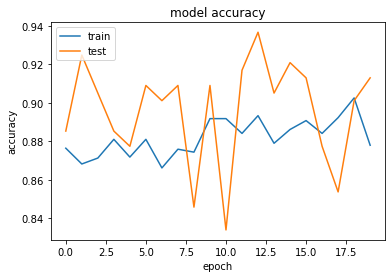

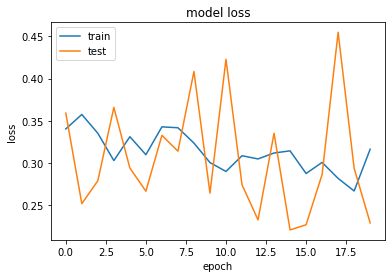

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

  ## VGG16

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense
from glob import glob

In [75]:
Image_size = [224,224]

train_path = '../input/cotton-disease-dataset/Cotton Disease/train'
test_path = '../input/cotton-disease-dataset/Cotton Disease/test'

In [76]:
vgg16 = VGG16(input_shape = Image_size + [3], weights = 'imagenet', include_top = False)

In [77]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [78]:
# freez the pretrained structure
for layer in vgg16.layers:
    layer.trainable = False

In [79]:
number_of_classes = glob('../input/cotton-disease-dataset/Cotton Disease/train/*')
number_of_classes

['../input/cotton-disease-dataset/Cotton Disease/train/fresh cotton plant',
 '../input/cotton-disease-dataset/Cotton Disease/train/fresh cotton leaf',
 '../input/cotton-disease-dataset/Cotton Disease/train/diseased cotton plant',
 '../input/cotton-disease-dataset/Cotton Disease/train/diseased cotton leaf']

In [80]:
flatten_layer = Flatten()(vgg16.output)

In [94]:
output_layer = Dense(len(number_of_classes),activation = 'softmax')(flatten_layer)

In [95]:
vgg16_model = Model(inputs = vgg16.input,outputs = output_layer)

In [96]:
vgg16_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [99]:
vgg16_model.compile(loss= 'categorical_crossentropy',
                   optimizer = 'adam',
                   metrics = ['accuracy'])

In [19]:

train_data = train_datagenerator.flow_from_directory('../input/cotton-disease-dataset/Cotton Disease/train',
                                                    target_size = (224,224),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')
test_data = test_datagenerator.flow_from_directory('../input/cotton-disease-dataset/Cotton Disease/test',
                                                    target_size = (224,224),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')

Found 1951 images belonging to 4 classes.
Found 106 images belonging to 4 classes.


In [102]:
history = vgg16_model.fit_generator(train_data,validation_data= test_data,epochs = 6,
                                   steps_per_epoch=len(train_data),validation_steps=len(test_data))

Epoch 1/6
61/61 [==============================] - 36s 595ms/step - loss: 0.0979 - accuracy: 0.9687 - val_loss: 0.1447 - val_accuracy: 0.9528
Epoch 2/6
61/61 [==============================] - 36s 585ms/step - loss: 0.0728 - accuracy: 0.9764 - val_loss: 0.1488 - val_accuracy: 0.9528
Epoch 3/6
61/61 [==============================] - 36s 584ms/step - loss: 0.0825 - accuracy: 0.9769 - val_loss: 0.1288 - val_accuracy: 0.9528
Epoch 4/6
61/61 [==============================] - 35s 575ms/step - loss: 0.0563 - accuracy: 0.9877 - val_loss: 0.1326 - val_accuracy: 0.9528
Epoch 5/6
61/61 [==============================] - 36s 589ms/step - loss: 0.0924 - accuracy: 0.9677 - val_loss: 0.2698 - val_accuracy: 0.8868
Epoch 6/6
61/61 [==============================] - 35s 578ms/step - loss: 0.0827 - accuracy: 0.9657 - val_loss: 0.1652 - val_accuracy: 0.9528


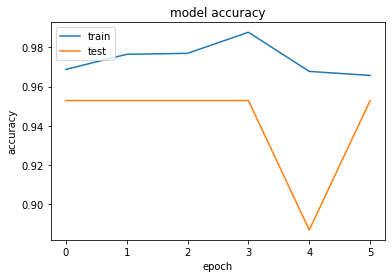

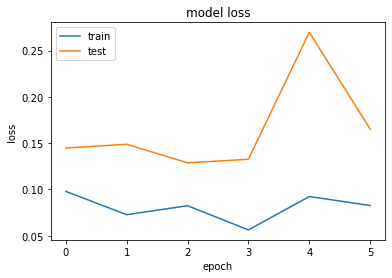

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## AlexNet

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

In [20]:
"""
Building AlexNet Model.
"""
model = Sequential()
# Block 1
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())
# Block 2
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())
# Block 3
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# Block 4
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# Block 5
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())
# Flattening
model.add(Flatten())
# Dense Layer block 1
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
model.add(Dropout(0.4)) # Add Dropout to prevent overfitting
model.add(BatchNormalization())
# Dense Layer block 2
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
# Dense Layer block 3
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
# Additional dense
model.add(Dense(128))
model.add(Activation('relu'))
# Output Layer
model.add(Dense(4))
model.add(Activation('softmax'))

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_29 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_30 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 256)        

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

history = model.fit_generator(train_data,validation_data=test_data,epochs = 10,
                                   steps_per_epoch=len(train_data),validation_steps=len(test_data))

Epoch 1/10
61/61 [==============================] - 45s 739ms/step - loss: 1.1731 - accuracy: 0.5064 - val_loss: 4.6152 - val_accuracy: 0.4245
Epoch 2/10
61/61 [==============================] - 45s 735ms/step - loss: 1.1217 - accuracy: 0.5141 - val_loss: 5.8658 - val_accuracy: 0.2925
Epoch 3/10
61/61 [==============================] - 44s 721ms/step - loss: 1.0104 - accuracy: 0.5546 - val_loss: 1.7382 - val_accuracy: 0.4340
Epoch 4/10
61/61 [==============================] - 43s 701ms/step - loss: 1.0046 - accuracy: 0.5777 - val_loss: 3.6587 - val_accuracy: 0.3113
Epoch 5/10
61/61 [==============================] - 44s 727ms/step - loss: 0.9334 - accuracy: 0.6007 - val_loss: 1.4761 - val_accuracy: 0.4151
Epoch 6/10
43/61 [====================>.........] - ETA: 11s - loss: 0.8819 - accuracy: 0.6102

KeyboardInterrupt: 

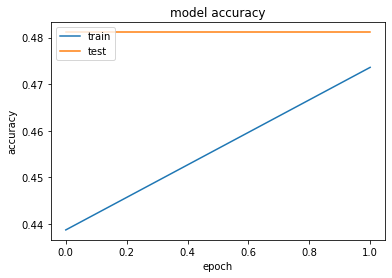

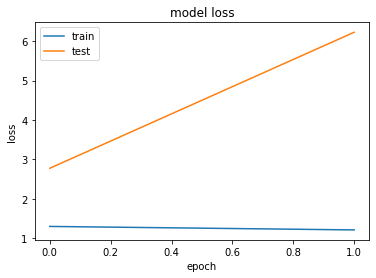

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
import numpy as np
from tensorflow.keras.preprocessing import image
predictions = ["diseased cotton leaf","diseased cotton plant","fresh cotton leaf","fresh cotton plant"]
test_image = image.load_img('../input/cotton-disease-dataset/Cotton Disease/val/fresh cotton leaf/d (26)_iaip.jpg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
predictions[result.argmax()]

'fresh cotton leaf'

* ## Please upvote if you like the notebook and comment your suggestion which models should be added.